<a href="https://colab.research.google.com/github/thunder913/Deep-Learning/blob/main/stocks_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import kagglehub
import numpy as np
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense, Concatenate
from sklearn.model_selection import train_test_split


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Stocks LSTM Prediction

In [6]:
import pdb

In [7]:
google_drive_path = 'drive/MyDrive/DL_Pickles/'
local_path = './pickles/'

path = kagglehub.dataset_download("tsaustin/us-historical-stock-prices-with-earnings-data")

stock_prices_path = f"{path}/stocks_latest/stock_prices_latest.csv"

stock_data_path = f"./{google_drive_path}/stock_data_processed.pkl"

In [8]:
def calculate_rsi(group, period = 14):
    delta = group['close'].diff()

    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / np.where(avg_loss != 0, avg_loss, 1)

    group['RSI'] = 100 - (100 / (1 + rs))

    return group

def calculate_macd(group, short_window=12, long_window=26, signal_window=9):
    # Calculate EMA short and long
    ema_short = group['close'].ewm(span=short_window, adjust=False).mean()
    ema_long = group['close'].ewm(span=long_window, adjust=False).mean()

    # Calculate MACD and Signal Line
    group['MACD'] = ema_short - ema_long
    group['Signal_Line'] = group['MACD'].ewm(span=signal_window, adjust=False).mean()

    return group

In [9]:
def get_peak_price_and_days_ago(df):
    """
    Calculate the peak price over a rolling 90-day window and determine the number of days
    since the peak price for each row in the DataFrame.
    """

    #df['peak_price'] = df['close'].rolling(window=90, min_periods=1).max()
    #peak_day_index = df['close'].rolling(window=90, min_periods=1).apply(lambda x: (len(x) - 1 - x.argmax()), raw=False)
    #df['peak_days_ago'] = peak_day_index.fillna(0).astype(int)  # Fill NaN for rows that don't have enough data
    return df

def process_ticker_data(df):
    """
    Add historical price features for specific days ago for each stock (grouped by ticker).
    Also calculate the peak price and days since the peak price for each stock.
    """

    print('Calculated RSI')
    # Calculate RSI (14-day by default)
    df = df.groupby('ticker', group_keys=False).apply(calculate_rsi)

    print('Calculated moving averages')
    # Add moving averages
    moving_average_windows = [5, 10, 20, 50, 100, 200]  # Specify moving average windows
    for window in moving_average_windows:
        df[f'{window}_day_MA'] = df.groupby('ticker')['close'].rolling(window=window, min_periods=1).mean().reset_index(level=0, drop=True)

    print('Calculated MACD')
    # Calculate MACD and Signal Line

    df = df.groupby('ticker', group_keys=False).apply(calculate_macd)

    print('Calculated price days ago')
    # Add columns for prices X days ago
    #for days in [1,2,3,4,5, 10, 15, 30, 60, 90]:
    #    df[f'price_{days}_days_ago'] = df.groupby('ticker')['close'].shift(days)

    df = df.groupby('ticker', group_keys=False).apply(get_peak_price_and_days_ago)

    # Remove the first 200 rows for each ticker
    df = df.groupby('ticker').apply(lambda group: group.iloc[200:]).reset_index(drop=True)

    return df

In [10]:
def getTidiedStockData():
    """
    Read and tidy the stock data dataset. If the processed stock data already exists as a pickle file,
    it loads and returns the data. Otherwise, it processes the raw stock data, cleans it, adds features,
    and saves the tidy data to a pickle file for future use.
    """

    # Check if the file exists
    if os.path.exists(stock_data_path):
        return pd.read_pickle(stock_data_path)

    # Read the basic data and some tidying
    stock_data = pd.read_csv(stock_prices_path)
    stock_data_tidy = stock_data

    stock_data_tidy.date = pd.to_datetime(stock_data_tidy.date)
    stock_data_tidy = stock_data_tidy.rename(columns={'symbol': 'ticker'})
    stock_data_tidy = stock_data_tidy.drop(columns=['split_coefficient'])

    stock_data_tidy = stock_data_tidy.sort_values(by=['ticker', 'date'], ascending=[True, True])

    stock_data_tidy = process_ticker_data(stock_data_tidy)

    # Encode labels
    le = LabelEncoder()
    stock_data_tidy['ticker_encoded'] = le.fit_transform(stock_data_tidy['ticker'])

    stock_data_tidy.to_pickle(stock_data_path)

    return stock_data_tidy

In [11]:
stock_data_tidy = getTidiedStockData()

In [12]:
stock_data_tidy.columns

Index(['ticker', 'date', 'open', 'high', 'low', 'close', 'close_adjusted',
       'volume', 'RSI', '5_day_MA', '10_day_MA', '20_day_MA', '50_day_MA',
       '100_day_MA', '200_day_MA', 'MACD', 'Signal_Line', 'ticker_encoded'],
      dtype='object')

In [13]:
stock_data_tidy = stock_data_tidy.drop(columns=['open', 'high', 'low', 'close_adjusted', 'volume'])

In [14]:
stock_data_tidy['day_of_week'] = stock_data_tidy['date'].dt.dayofweek

In [15]:
def plot_stock_chart(stock_data_tidy, ticker, start_date=None, end_date=None):
    """
    Plot a stock chart for a specific ticker.

    Parameters:
        stock_data_tidy (DataFrame): The DataFrame containing stock data.
        ticker (str): The ticker to plot.
        start_date (str): Optional start date (e.g., '2023-01-01').
        end_date (str): Optional end date (e.g., '2023-12-31').
    """
    # Filter data for the specific ticker and date range
    stock_data_tidy['date'] = pd.to_datetime(stock_data_tidy['date'])
    filtered_data = stock_data_tidy[stock_data_tidy['ticker'] == ticker]

    if start_date:
        filtered_data = filtered_data[filtered_data['date'] >= start_date]
    if end_date:
        filtered_data = filtered_data[filtered_data['date'] <= end_date]

    # Ensure data is sorted by date
    filtered_data = filtered_data.sort_values(by='date')

    # Plot the stock chart
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_data['date'], filtered_data['close'], label='Close Price', color='blue', linewidth=2)

    # Add moving averages if they exist in the DataFrame
    for col in ['5_day_MA', '10_day_MA', '50_day_MA']:
        if col in filtered_data.columns:
            plt.plot(filtered_data['date'], filtered_data[col], label=col, linestyle='--')

    # Chart settings
    plt.title(f"Stock Chart for {ticker}", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price", fontsize=12)
    plt.legend(loc="best", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

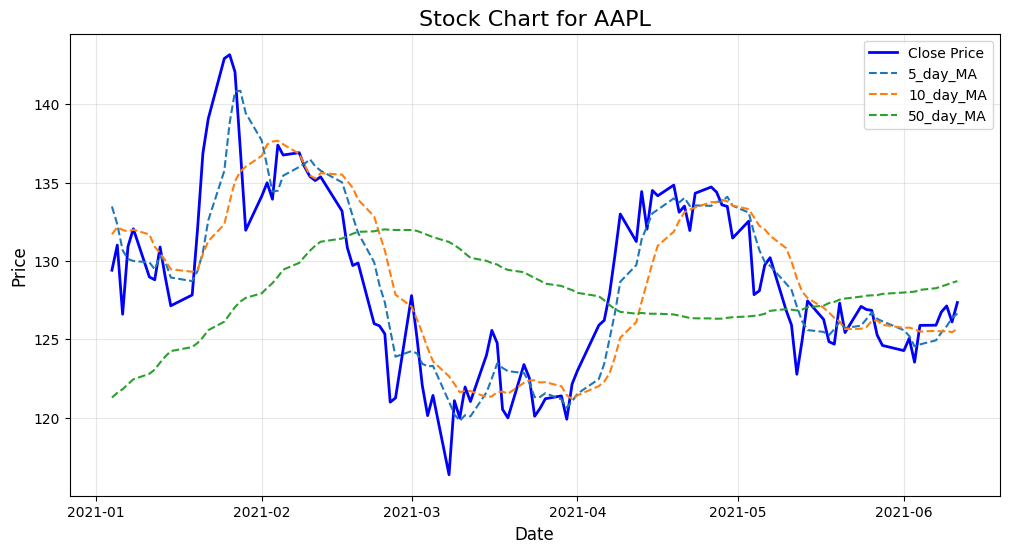

In [16]:
plot_stock_chart(stock_data_tidy, ticker='AAPL', start_date='2021-01-01', end_date='2022-12-31')

In [17]:
stock_data_tidy.columns

Index(['ticker', 'date', 'close', 'RSI', '5_day_MA', '10_day_MA', '20_day_MA',
       '50_day_MA', '100_day_MA', '200_day_MA', 'MACD', 'Signal_Line',
       'ticker_encoded', 'day_of_week'],
      dtype='object')

In [18]:
numerical_columns = [
    'close', 'RSI', '5_day_MA', '10_day_MA',
    '20_day_MA', '50_day_MA', '100_day_MA', '200_day_MA',
    'MACD', 'Signal_Line', 'day_of_week'
]

scaler = MinMaxScaler()

stock_data_tidy[numerical_columns] = scaler.fit_transform(stock_data_tidy[numerical_columns])

print(stock_data_tidy.head())

  ticker       date         close       RSI      5_day_MA     10_day_MA  \
0      A 2000-09-05  6.811722e-08  0.848980  3.404980e-07  6.686680e-07   
1      A 2000-09-06  6.612317e-08  0.791932  3.371929e-07  6.681172e-07   
2      A 2000-09-07  6.819434e-08  0.783346  3.377437e-07  6.696375e-07   
3      A 2000-09-08  6.529691e-08  0.572147  3.358158e-07  6.690866e-07   
4      A 2000-09-11  6.254269e-08  0.397373  3.301641e-07  6.671587e-07   

   20_day_MA  50_day_MA  100_day_MA  200_day_MA      MACD  Signal_Line  \
0   0.000001   0.000003    0.000007    0.000016  0.000286     0.000746   
1   0.000001   0.000003    0.000007    0.000016  0.000286     0.000746   
2   0.000001   0.000003    0.000007    0.000016  0.000286     0.000746   
3   0.000001   0.000003    0.000007    0.000016  0.000286     0.000746   
4   0.000001   0.000003    0.000007    0.000016  0.000286     0.000746   

   ticker_encoded  day_of_week  
0               0         0.25  
1               0         0.50  
2    

In [19]:
unique_count = stock_data_tidy['ticker'].nunique()

In [20]:
def create_simple_lstm_model(sequence_length, num_features, lstm_units=64, dropout_rate=0.3):
    return Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=(sequence_length, num_features), name="lstm_layer_1"),
        Dropout(dropout_rate, name="dropout_1"),

        LSTM(lstm_units, return_sequences=False, name="lstm_layer_2"),
        Dropout(dropout_rate, name="dropout_2"),

        Dense(1, activation='linear', name="output")
    ], name="Simple_LSTM_Model")

In [21]:
def preprocess_data(stock_data_tidy, numerical_columns, sequence_length):
    data = stock_data_tidy[numerical_columns].values

    # Create sequences
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i - sequence_length:i])
        y.append(data[i, 0])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [22]:
def create_lstm_model(sequence_length, num_features, lstm_units=64, dropout_rate=0.3):
    """
    Creates an LSTM model for stock prediction using only numerical data.

    Parameters:
        sequence_length (int): Length of input sequences.
        num_features (int): Number of numerical features.
        lstm_units (int): Number of units in the LSTM layers.
        dropout_rate (float): Dropout rate for regularization.

    Returns:
        model: Compiled LSTM model.
    """
    # Input for numerical features
    numerical_input = Input(shape=(sequence_length, num_features), name="numerical_input")

    # LSTM layers with dropout
    x = LSTM(lstm_units, return_sequences=True, name="lstm_layer_1")(numerical_input)
    x = Dropout(dropout_rate, name="dropout_1")(x)

    x = LSTM(lstm_units, return_sequences=False, name="lstm_layer_2")(x)
    x = Dropout(dropout_rate, name="dropout_2")(x)

    # Fully connected output layer
    output = Dense(1, activation='linear', name="output")(x)

    # Define the model
    model = Model(inputs=numerical_input, outputs=output, name="LSTM_Stock_Model")
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return model


In [23]:
lstm_model = create_lstm_model(sequence_length=30, num_features=len(numerical_columns))

In [24]:
lstm_model.summary()

Model: "LSTM_Stock_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ numerical_input (InputLayer)         │ (None, 30, 11)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_1 (LSTM)                  │ (None, 30, 64)              │          19,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_2 (LSTM)                  │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,545 (205.25 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

processed_data_path = google_drive_path + 'processed_data/'

def preprocess_grouped_data(stock_data_tidy, numerical_columns, target_column, sequence_length):
    tickers = stock_data_tidy["ticker_encoded"].unique()

    for ticker in tickers:
        ticker_data = stock_data_tidy[stock_data_tidy["ticker_encoded"] == ticker].sort_values(by="date")
        numerical_data = ticker_data[numerical_columns].values

        print(ticker_data.ticker.unique())

        if len(ticker_data) > sequence_length:
            x_ticker = sliding_window_view(numerical_data, window_shape=(sequence_length, len(numerical_columns)))
            x_ticker = x_ticker.reshape(-1, sequence_length, len(numerical_columns))

            y_ticker = ticker_data[target_column].values[sequence_length-1:]

            np.save(os.path.join(processed_data_path, f"x_ticker_{ticker}.npy"), x_ticker)
            np.save(os.path.join(processed_data_path, f"y_ticker_{ticker}.npy"), y_ticker)

In [54]:
preprocess_grouped_data(stock_data_tidy, numerical_columns, 'close', 30)

Предаденият резултат е скъсен до последните 5000 реда.
['FINS']
['FINX']
['FIS']
['FISI']
['FISV']
['FIT']
['FITB']
['FITBI']
['FITBO']
['FITBP']
['FIV']
['FIVE']
['FIVN']
['FIX']
['FIXD']
['FIXX']
['FIZZ']
['FJP']
['FKO']
['FKU']
['FL']
['FLAG']
['FLAT']
['FLC']
['FLDM']
['FLEX']
['FLGT']
['FLIC']
['FLIR']
['FLKS']
['FLL']
['FLMN']
['FLMNW']
['FLN']
['FLNT']
['FLO']
['FLOW']
['FLR']
['FLS']
['FLT']
['FLUX']
['FLWS']
['FLXN']
['FLXS']
['FLY']
['FMAO']
['FMB']
['FMBH']
['FMBI']
['FMBIO']
['FMBIP']
['FMC']
['FMCI']
['FMHI']
['FMI']
['FMK']
['FMN']
['FMNB']
['FMO']
['FMS']
['FMSA']
['FMTX']
['FMX']
['FMY']
['FN']
['FNB']
['FNBG']
['FNCB']
['FND']
['FNF']
['FNGN']
['FNHC']
['FNJN']
['FNK']
['FNKO']
['FNLC']
['FNSR']
['FNTE']
['FNTEU']
['FNTEW']
['FNV']
['FNWB']
['FNX']
['FNY']
['FOANC']
['FOCS']
['FOE']
['FOF']
['FOGO']
['FOLD']
['FOMX']
['FONE']
['FONR']
['FOR']
['FORD']
['FORK']
['FORM']
['FORR']
['FORTY']
['FOSL']
['FOX']
['FOXA']
['FOXF']
['FPA']
['FPAC']
['FPAY']
['FPAYW']
['FPF']
['F

In [34]:
import tensorflow as tf
import glob

def create_tf_dataset(batch_size, sequence_length):
    """
    Creates a TensorFlow dataset that streams data from saved files.

    Parameters:
        batch_size (int): Batch size for training.

    Returns:
        tf.data.Dataset: A TensorFlow dataset for training.
    """
    # Find all saved files
    x_files = sorted(glob.glob(os.path.join(processed_data_path, "x_ticker_*.npy")))
    y_files = sorted(glob.glob(os.path.join(processed_data_path, "y_ticker_*.npy")))

    def generator():
        i = 0
        for x_file, y_file in zip(x_files, y_files):

            print('Ticker:', x_file.split('_')[-1].split('.')[0])
            x = np.load(x_file)
            y = np.load(y_file)

            if np.isnan(x).any() or np.isnan(y).any() or np.isinf(x).any() or np.isinf(y).any():
              print(f"Invalid values in files: {x_file}, {y_file}")
            for i in range(len(x) - 1): # TODO remove the -1 and relearn the dataset
                i += 1
                print(f"Generator called {i} times")
                yield x[i], y[i]

    # Create the dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(sequence_length, len(numerical_columns)), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )

    # Shuffle, batch, and prefetch for training
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [32]:
from tensorflow.keras.backend import clear_session

# Clear the default graph and session
clear_session()

In [ ]:
batch_size = 32
sequence_length = 30

dataset = create_tf_dataset(batch_size, sequence_length)

train_size = int(0.9 * len(glob.glob(os.path.join(processed_data_path, "x_ticker_*.npy"))))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Define and compile the model
model = create_lstm_model(sequence_length=sequence_length, num_features=len(numerical_columns))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1, steps_per_epoch=1, validation_steps = 1)

Предаденият резултат е скъсен до последните 5000 реда.
Generator called 593 times
Generator called 594 times
Generator called 595 times
Generator called 596 times
Generator called 597 times
Generator called 598 times
Generator called 599 times
Generator called 600 times
Generator called 601 times
Generator called 602 times
Generator called 603 times
Generator called 604 times
Generator called 605 times
Generator called 606 times
Generator called 607 times
Generator called 608 times
Generator called 609 times
Generator called 610 times
Generator called 611 times
Generator called 612 times
Generator called 613 times
Generator called 614 times
Generator called 615 times
Generator called 616 times
Generator called 617 times
Generator called 618 times
Generator called 619 times
Generator called 620 times
Generator called 621 times
Generator called 622 times
Generator called 623 times
Generator called 624 times
Generator called 625 times
Generator called 626 times
Generator called 627 times


In [35]:
# Convert to tf.data.Dataset
batch_size = 32

# Shuffle, batch, and prefetch for efficient training
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)

NameError: name 'dataset' is not defined

In [34]:
# Determine split sizes
train_size = int(0.8 * len(x))
val_size = len(x) - train_size

# Create train and validation datasets
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

NameError: name 'x' is not defined

In [94]:
history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    verbose=1
)

Epoch 1/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.6094e-04 - mae: 0.0123
Epoch 2/20
 27/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1119e-05 - mae: 0.0036

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.9081e-05 - mae: 0.0034
Epoch 3/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.3127e-06 - mae: 0.0024
Epoch 4/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 5.7372e-06 - mae: 0.0019
Epoch 5/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 3.9570e-06 - mae: 0.0015
Epoch 6/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.5692e-06 - mae: 0.0012
Epoch 7/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8980e-06 - mae: 0.0011
Epoch 8/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.3881e-06 - mae: 9.2780e-04
Epoch 9/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1546e-06 - mae: 8.3434e-04
Epoch 10/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 8.8186e-07 - mae: 7.3113e-04
Epoch 11/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 7.5131e-07 - mae: 6.6927e-04
Epoch 12/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.3860e-07 - mae: 6.2218e-04
Epoch 13/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step 

In [26]:
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping

# Define paths and parameters
data_folder = processed_data_path
sequence_length = 30  # Adjust based on your data
num_features = 5      # Adjust based on your feature count
lstm_units = 64
dropout_rate = 0.3
batch_size = 32       # Adjust based on your memory and data
epochs = 50

In [51]:
# Create a list of tickers
x_files = [f for f in os.listdir(data_folder) if f.startswith("x_ticker_")]
tickers = [f.split("_")[-1].replace(".npy", "") for f in x_files]

def data_generator(tickers, data_folder):
    """Yields data for one ticker per epoch."""
    while True:
        for ticker in tickers:
            returned_count = 0;
            print('\nTicker', ticker)
            # Load data for the current ticker
            x_path = os.path.join(data_folder, f"x_ticker_{ticker}.npy")
            y_path = os.path.join(data_folder, f"y_ticker_{ticker}.npy")

            x_data = np.load(x_path)
            y_data = np.load(y_path)

            # Ensure data is compatible with the batch size
            steps_per_epoch = len(x_data) // batch_size
            x_data = x_data[:steps_per_epoch * batch_size]
            y_data = y_data[:steps_per_epoch * batch_size]

            # Reshape and yield in batches
            for i in range(steps_per_epoch):
                x_batch = x_data[i * batch_size: (i + 1) * batch_size]
                y_batch = y_data[i * batch_size: (i + 1) * batch_size]
                returned_count += len(x_batch)
                yield x_batch, y_batch

            print('\nReturned total rows: ', returned_count)
            print('\nMax rows: ', len(x_data))

In [52]:
train_gen = data_generator(tickers, data_folder)

In [53]:
early_stopping = EarlyStopping(monitor="loss", patience=3, restore_best_weights=True)

In [54]:
# Create the model
# Define callbacks (optional)

# Train the model
lstm_model.fit(
    train_gen,
    steps_per_epoch=1000,
    epochs=epochs,
    callbacks=[early_stopping]
)

print("Training complete!")



Ticker 0
Epoch 1/50
 161/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.2874e-07 - mae: 3.7800e-04
Returned total rows:  5184

Max rows:  5184

Ticker 1
 188/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.2939e-07 - mae: 3.7864e-04
Returned total rows:  896

Max rows:  896

Ticker 2
 196/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.2944e-07 - mae: 3.7869e-04
Returned total rows:  320

Max rows:  320

Ticker 3
 353/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.2581e-07 - mae: 3.7528e-04
Returned total rows:  5248

Max rows:  5248

Ticker 4
 394/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.2379e-07 - mae: 3.7339e-04
Returned total rows:  1088

Max rows:  1088

Ticker 5
 485/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.2087e-07 - mae: 3.7061e-04
Returned total rows:  3104

Max rows:  3104

Ticker 7
 607/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.1660e-07 - mae: 3.6653e-04
Returned total rows:  3712

Max rows:  3712

Ticker 8
 663/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - 

In [58]:
aapl_data = stock_data_tidy[stock_data_tidy == 'AAPL']

In [ ]:
X = aapl_data[numerical_columns].values
y = aapl_data['close'].values

# Reshape for LSTM input (sequence_length, num_features)
sequence_length = 30  # Assume sequence length
num_features = X.shape[1]

X_sequences = []
y_sequences = []

for i in range(sequence_length, len(X)):
    X_sequences.append(X[i-sequence_length:i])
    y_sequences.append(y[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Make predictions
y_pred = lstm_model.predict(X_sequences)

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_sequences, label='Actual Prices', alpha=0.8)
plt.plot(y_pred, label='Predicted Prices', alpha=0.8)
plt.title('Actual vs Predicted Prices for AAPL')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))
